In [1]:
import os
import math
import pandas as pd
import numpy as np
import random
import dateutil.parser
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model

In [2]:
csv_files = ['./data/'+file for file in os.listdir('./data/') if '.csv' in file]
df_imported = pd.concat([pd.read_csv(file) for file in csv_files])
df_imported = df_imported.rename(columns={'Unnamed: 0': 'record_time'})
df_imported = df_imported.drop_duplicates(subset='record_time', keep='last')
df_imported = df_imported.set_index('record_time')
df_imported.count()

$                           104
dateStamp                    14
dew_point                   104
modelCode                    14
modelRun                     14
periodSchedule               14
pressure                    104
screen_relative_humidity    104
sea_temperature             104
surf_max                     14
surf_min                     14
swell_direction1             14
swell_direction2             14
swell_direction3             14
swell_height1                14
swell_height2                14
swell_height3                14
swell_period1                14
swell_period2                14
swell_period3                14
temperature                 104
wave_height                 104
wave_period                 104
wind_direction              104
wind_speed                  104
dtype: int64

available target values: 14
target values after interpolation: 95


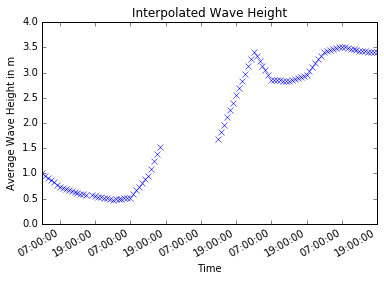

In [71]:
target_var = 'surf_avg'
s_target = pd.Series( (df_imported['surf_max'] + df_imported['surf_min']) / 2, name=target_var )
print('available target values:', s_target.count())
# fill NAs with linearly interpolated data
# TODO: Only for points which are max. 5h apart
s_target = s_target.interpolate()
print('target values after interpolation:', s_target.count())


def plot_datetime_series(series, title, xlabel='Time', ylabel='', label=['b-', 'g-', 'r-', 'y-']):
    if(type(series) is not list):
        series = [series]
    if(type(label) is not list):
        label = [label]
    for i, s in enumerate(series):
        s = s.copy()
        s.sort_index(inplace=True)
        plt.plot_date(
            matplotlib.dates.date2num(
                [dateutil.parser.parse(dt) for dt in s.index]
            ), 
            s.values,
            label[i]
        )
    if title:
        plt.title(title)
    if ylabel != '':
        plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.gcf().autofmt_xdate()
    if len(series) > 1:
        plt.legend([s.name for s in series], loc=2)
    plt.show()
    
plot_datetime_series(s_target, 'Interpolated Wave Height', 'Time', 'Average Wave Height in m', 'bx')

In [8]:
df_explanatory = df_imported[['wind_direction','dew_point', 'screen_relative_humidity', 'pressure', 'wind_speed', 'sea_temperature', 'temperature', 'wave_height', 'wave_period']]
df_explanatory = df_explanatory.dropna()
df_explanatory
print(df_explanatory['wind_direction'].head())
compass_directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
df_explanatory['wind_direction'] = df_explanatory['wind_direction'].apply(lambda dir: (360 / len(compass_directions)) * compass_directions.index(dir))
print('\nbecomes',df_explanatory['wind_direction'].head())

record_time
2016-05-14T16:00:00+00:00     NW
2016-05-14T17:00:00+00:00    NNW
2016-05-14T18:00:00+00:00     NW
2016-05-14T19:00:00+00:00     NW
2016-05-14T20:00:00+00:00    WNW
Name: wind_direction, dtype: object

becomes record_time
2016-05-14T16:00:00+00:00    315.0
2016-05-14T17:00:00+00:00    337.5
2016-05-14T18:00:00+00:00    315.0
2016-05-14T19:00:00+00:00    315.0
2016-05-14T20:00:00+00:00    292.5
Name: wind_direction, dtype: float64


In [9]:
print('Data types of columns')
pd.DataFrame(df_explanatory.columns,[str(df_explanatory[column].dtype) for column in df_explanatory.columns])

Data types of columns


,0
float64,wind_direction
float64,dew_point
float64,screen_relative_humidity
int64,pressure
int64,wind_speed
float64,sea_temperature
float64,temperature
float64,wave_height
float64,wave_period


In [10]:
df_train = pd.merge(df_explanatory, pd.DataFrame(s_target), left_index=True, right_index=True).dropna()
df_train.count()

wind_direction              95
dew_point                   95
screen_relative_humidity    95
pressure                    95
wind_speed                  95
sea_temperature             95
temperature                 95
wave_height                 95
wave_period                 95
surf_avg                    95
dtype: int64

                              live
wind_direction            0.350006
dew_point                -0.043747
screen_relative_humidity -0.285368
pressure                 -0.928169
wind_speed                0.839898
sea_temperature           0.378666
temperature               0.335792
wave_height               0.872452
wave_period               0.042773


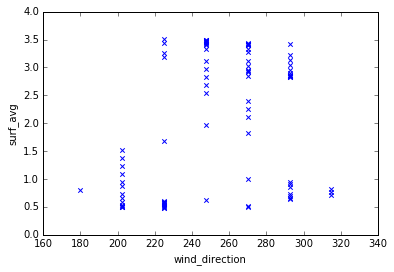

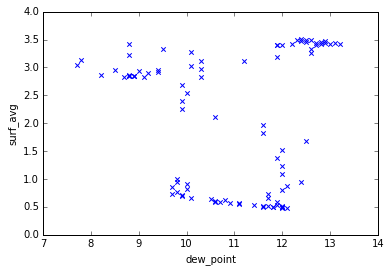

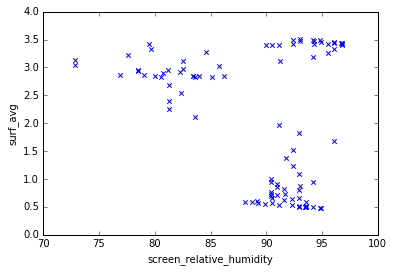

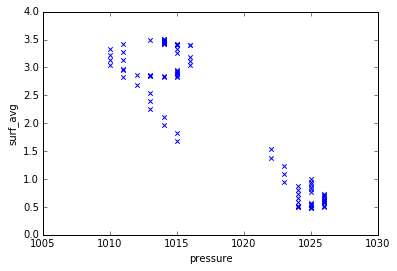

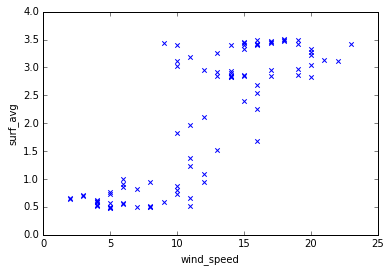

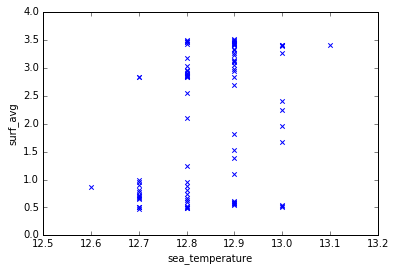

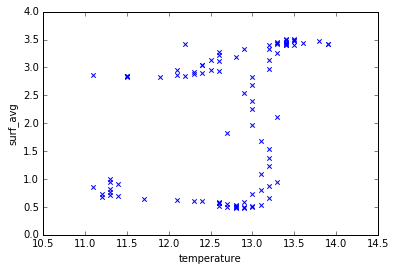

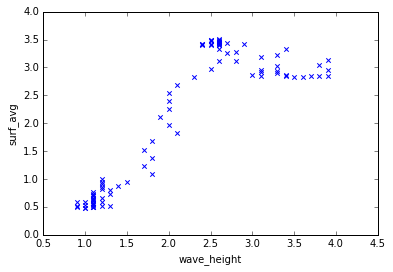

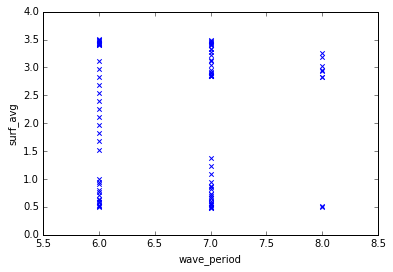

In [11]:
target_correlations = pd.Series([df_train[column].corr(df_train[target_var]) for column in df_explanatory.columns])
target_correlations.name = 'live'
target_correlations = pd.DataFrame(target_correlations)
target_correlations.index = df_explanatory.columns
print(target_correlations)
#fix, axes =plt.subplots(nrows=len(df_explanatory.columns), figsize=(8,8))
for column in df_explanatory.columns:
    df_train.plot.scatter(x=column, y=target_var, marker='x')

In [74]:
#df_ewma3 = pd.ewma(df_explanatory, span=3)
for span in range(3,30):
    target_correlations['ewma'+str(span)] = pd.Series([ pd.ewma(df_train[column], span=span).corr(df_train[target_var]) for column in df_explanatory.columns], index=df_explanatory.columns)
target_correlations
#column = 'pressure'
#pd.ewma(df_train[column], span=3).corr(df_train[target_var])

,live,ewma3,ewma4,ewma5,ewma6,ewma7,ewma8,ewma9,ewma10,ewma11,...,ewma20,ewma21,ewma22,ewma23,ewma24,ewma25,ewma26,ewma27,ewma28,ewma29
wind_direction,0.350006,0.338512,0.325416,0.310599,0.294860,0.278693,0.262409,0.246199,0.230173,0.214392,...,0.084722,0.071656,0.058859,0.046333,0.034081,0.022105,0.010407,-0.001011,-0.012149,-0.023008
dew_point,-0.043747,-0.032987,-0.028965,-0.025645,-0.022865,-0.020523,-0.018542,-0.016852,-0.015387,-0.014081,...,-0.001994,-0.000144,0.001843,0.003963,0.006213,0.008588,0.011080,0.013681,0.016385,0.019181
screen_relative_humidity,-0.285368,-0.302176,-0.311110,-0.320538,-0.330408,-0.340725,-0.351494,-0.362694,-0.374274,-0.386164,...,-0.494044,-0.505009,-0.515634,-0.525904,-0.535808,-0.545339,-0.554496,-0.563281,-0.571697,-0.579750
pressure,-0.928169,-0.941188,-0.945834,-0.949722,-0.953006,-0.955807,-0.958216,-0.960302,-0.962115,-0.963689,...,-0.970109,-0.970204,-0.970217,-0.970160,-0.970040,-0.969868,-0.969650,-0.969394,-0.969107,-0.968793
wind_speed,0.839898,0.878853,0.888813,0.897211,0.904641,0.911362,0.917507,0.923151,0.928339,0.933100,...,0.960242,0.961896,0.963355,0.964636,0.965757,0.966734,0.967581,0.968314,0.968944,0.969482
sea_temperature,0.378666,0.446839,0.467841,0.487075,0.505125,0.522089,0.537988,0.552853,0.566736,0.579699,...,0.663869,0.670388,0.676466,0.682132,0.687416,0.692342,0.696935,0.701220,0.705217,0.708948
temperature,0.335792,0.369394,0.383850,0.397880,0.411641,0.425184,0.438518,0.451630,0.464495,0.477083,...,0.573410,0.581982,0.590131,0.597868,0.605207,0.612163,0.618752,0.624991,0.630897,0.636486
wave_height,0.872452,0.878246,0.880347,0.882641,0.885101,0.887660,0.890248,0.892797,0.895257,0.897584,...,0.910578,0.911219,0.911740,0.912154,0.912474,0.912709,0.912871,0.912967,0.913008,0.913000
wave_period,0.042773,0.068625,0.081715,0.096392,0.112579,0.129978,0.148232,0.166990,0.185944,0.204834,...,0.350037,0.362545,0.374339,0.385445,0.395893,0.405717,0.414947,0.423618,0.431762,0.439410


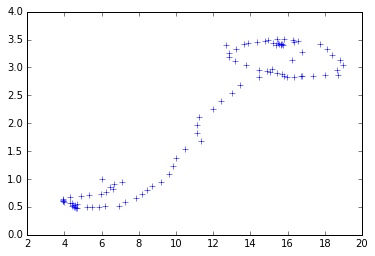

In [91]:
plt.plot(pd.ewma(df_train['wind_speed'], span=12), df_train[target_var], 'b+')

In [92]:
# randomly sample a train and test set
def split_dataset(df_in, percent_test):
    total_size = len(df_in)
    test_set_size = math.floor(percent_test * total_size)
    df_train = df_in.copy()
    record_labels = [ df_train.index[randint] for randint in random.sample(range(total_size), test_set_size) ]
    df_test = pd.DataFrame(df_train.loc[record_labels])
    df_train = df_train.drop(record_labels)
    return df_train, df_test

coefficients:  [ 0.01293972  2.69403867 -0.41664729 -0.06216841  0.02816573 -0.639668
 -2.02543915  0.67131989  0.01984758]


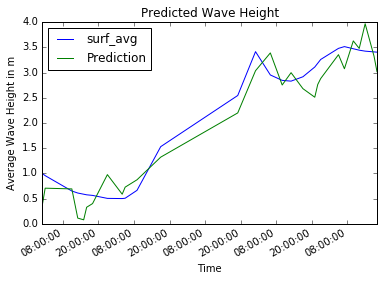

In [93]:
# perform predictionon unaveraged data
regr = linear_model.LinearRegression()
train_set, test_set = split_dataset(df_train, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
print('coefficients: ', coefficients)

predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set', 'Time', 'Average Wave Height in m')

coefficients:  [  3.13439966e-03   1.08163235e+01  -1.77507027e+00  -2.93540515e-01
  -2.22459079e-02  -2.08760063e-01  -1.06534965e+01   5.26682147e-03
   1.67597252e-01]
intercept:  477.305223996


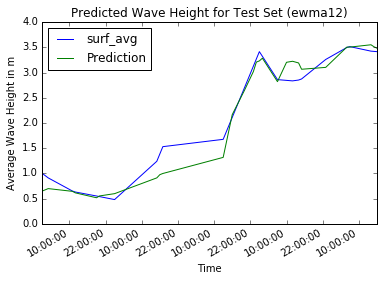

In [97]:
# perform prediction on ewma with span 12
regr = linear_model.LinearRegression()
df_ewma12 = pd.concat([pd.ewma(df_train[df_explanatory.columns], span=12), df_train[target_var]], axis=1)
train_set, test_set = split_dataset(df_ewma12, 0.3)
regr.fit(train_set[df_explanatory.columns].as_matrix(), train_set[target_var].as_matrix())
coefficients = regr.coef_
intercept = regr.intercept_
print('coefficients: ', coefficients)
print('intercept: ', intercept)

predictions = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set.index, name='Prediction')
plot_datetime_series([test_set[target_var], predictions], 'Predicted Wave Height for Test Set (ewma12)', 'Time', 'Average Wave Height in m')

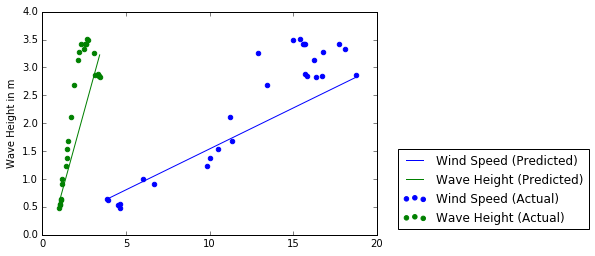

In [193]:
plt.scatter(
    test_set['wind_speed'],
    test_set[target_var],
    color='b'
)
plt.scatter(
    test_set['wave_height'],
    test_set[target_var],
    color='g'
)

predictions_wind_speed = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set['wind_speed'], name='Prediction').sort_index()
predictions_wave_height = pd.Series(regr.predict(test_set[df_explanatory.columns].as_matrix()), index=test_set['wave_height'], name='Prediction').sort_index()

plt.plot([test_set['wind_speed'].min(), test_set['wind_speed'].max()], [predictions_wind_speed.iloc[0], predictions_wind_speed.iloc[-1]])
plt.plot([test_set['wave_height'].min(), test_set['wave_height'].max()], [predictions_wave_height.iloc[0], predictions_wave_height.iloc[-1]])
plt.legend(['Wind Speed (Predicted)', 'Wave Height (Predicted)', 'Wind Speed (Actual)', 'Wave Height (Actual)'], bbox_to_anchor=(1.65, 0), loc='lower right')
plt.ylabel('Wave Height in m')